In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

import lightning.pytorch as pl
import torchmetrics

import torchvision.datasets as datasets
from torchvision import transforms
torch.set_float32_matmul_precision('medium')

In [2]:
# set device
device = torch.device('cuda' if torch.cuda.is_available() else 'mps')
device

device(type='cuda')

In [3]:
mean = [0.5071, 0.4867, 0.4408]
std = [0.2470, 0.2435, 0.2616]
train_transform = transforms.Compose([transforms.Resize((224,224)),
                                      transforms.AutoAugment(transforms.AutoAugmentPolicy.CIFAR10),
                                transforms.ToTensor(),
                                
                                
                               transforms.Normalize(mean,std)])

val_transform = transforms.Compose([transforms.Resize((227,227)),
                                transforms.ToTensor(),
                               transforms.Normalize(mean,std)])

In [4]:
class CIFAR100DataLoader(pl.LightningDataModule):
    def __init__(self,root,batch_size,num_workers):
        super(CIFAR100DataLoader,self).__init__()
        self.root = root
        self.batch_size = batch_size
        self.num_workers = num_workers
        
        
    def prepare_data(self):
        datasets.CIFAR100(root = self.root,train=True,download=True)
        datasets.CIFAR100(root = self.root,train=False,download=True)

    def setup(self, stage):
        train_dataset = datasets.CIFAR100(root = self.root,train=True,download=False,transform= train_transform)
        self.test_dataset =  datasets.CIFAR100(root = self.root,train=False,download=False,transform= val_transform)
        # Define the proportions for the split
        train_proportion = 0.8  # 80% for training
        val_proportion = 0.2  # 20% for validation

        # Calculate the sizes of training and validation sets based on the proportions
        train_size = int(train_proportion * len(train_dataset))
        val_size = len(train_dataset) - train_size
        
        # Use random_split to split the dataset
        self.train_dataset, self.val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])
        

    def train_dataloader(self):
        return torch.utils.data.DataLoader(dataset=self.train_dataset,batch_size=self.batch_size,shuffle=True,num_workers=self.num_workers,pin_memory=True)
    
    def val_dataloader(self):
        return torch.utils.data.DataLoader(dataset=self.val_dataset,batch_size=self.batch_size,shuffle=False,num_workers=self.num_workers,pin_memory=True)
    
    def test_dataloader(self):
        return torch.utils.data.DataLoader(dataset=self.test_dataset,batch_size=self.batch_size,shuffle=False,num_workers=self.num_workers,pin_memory=True)
   

In [5]:
root = "./data"
batch_size = 768
num_workers = 8
ds = CIFAR100DataLoader(root, batch_size, num_workers)

In [6]:
# # Sanity
# ds.prepare_data()
# ds.setup('valid')
# for data,label in ds.val_dataloader():
#     print(data.shape,label.shape)
#     break

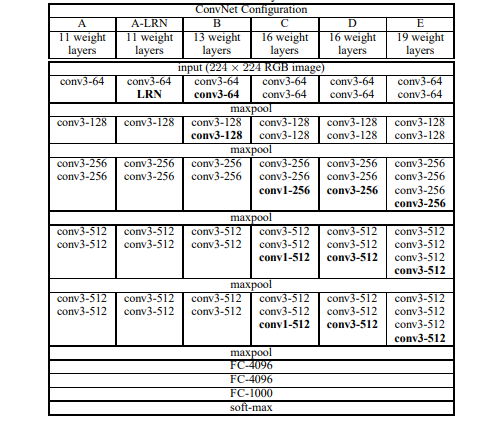

In [7]:
nn.Sequential(        nn.Conv2d(in_channels=3,out_channels=64,kernel_size=3,stride=4,padding=0),
                        nn.BatchNorm2d(64),
                        nn.ReLU(),
                      
                      nn.Conv2d(in_channels=96,out_channels=256,kernel_size=5,stride=1,padding=2),
                      nn.BatchNorm2d(256),
                      nn.ReLU(),
                      nn.MaxPool2d(kernel_size=2,stride=2),

                    nn.Conv2d(in_channels=256,out_channels=384,kernel_size=3,stride=1,padding=1),
                      nn.BatchNorm2d(384),
                      nn.ReLU(),

                    nn.Conv2d(in_channels=384,out_channels=384,kernel_size=3,stride=1,padding=1),
                      nn.BatchNorm2d(384),
                      nn.ReLU(),

                    nn.Conv2d(in_channels=384,out_channels=256,kernel_size=3,stride=1,padding=1),
                      nn.BatchNorm2d(256),
                      nn.ReLU(),
                      nn.MaxPool2d(kernel_size=3,stride=2),)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(4, 4))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (7): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (9): ReLU()
  (10): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (12): ReLU()
  (13): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (14): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (15): ReLU()
  (16): MaxPool2d(kernel_size=3, str

In [8]:
class AlexNet(pl.LightningModule):

    def __init__(self,num_spheres_per_class,margin=1.0):
        super().__init__()

        self.layers = nn.Sequential(
                      nn.Conv2d(in_channels=3,out_channels=96,kernel_size=11,stride=4,padding=0),
                      nn.BatchNorm2d(96),
                      nn.ReLU(),
                      nn.MaxPool2d(kernel_size=3,stride=2),
                      
                      nn.Conv2d(in_channels=96,out_channels=256,kernel_size=5,stride=1,padding=2),
                      nn.BatchNorm2d(256),
                      nn.ReLU(),
                      nn.MaxPool2d(kernel_size=2,stride=2),

                      nn.Conv2d(in_channels=256,out_channels=384,kernel_size=3,stride=1,padding=1),
                      nn.BatchNorm2d(384),
                      nn.ReLU(),

                      nn.Conv2d(in_channels=384,out_channels=384,kernel_size=3,stride=1,padding=1),
                      nn.BatchNorm2d(384),
                      nn.ReLU(),

                      nn.Conv2d(in_channels=384,out_channels=256,kernel_size=3,stride=1,padding=1),
                      nn.BatchNorm2d(256),
                      nn.ReLU(),
                      nn.MaxPool2d(kernel_size=3,stride=2),

                     nn.Flatten(),
                      
                    #   nn.Linear(6*6*256,4096),
                    #   nn.Dropout(0.2),
                    #   nn.SiLU(),

                    # nn.Linear(4096,4096),
                    #   nn.Dropout(0.2),
                    #   nn.SiLU(),

                    # nn.Linear(4096,100)
      
                         )
        num_classes = 100
        input_shape = 6*6*256
        self.num_classes = num_classes
        self.num_spheres_per_class = num_spheres_per_class
        self.margin = margin

        # Class-specific centers and radii
        self.centers = nn.Parameter(torch.Tensor(num_classes, num_spheres_per_class, input_shape))
        self.radii = nn.Parameter(torch.Tensor(num_classes, num_spheres_per_class))
        self.alphas = nn.Parameter(torch.Tensor(num_classes, num_spheres_per_class))

        # Xavier initialization
        nn.init.xavier_uniform_(self.centers)
        nn.init.constant_(self.radii, 1.0)
        nn.init.xavier_uniform_(self.alphas)
        
        self.linear = nn.Linear(num_spheres_per_class, num_classes)
        
        self.accuracy = torchmetrics.Accuracy(task="multiclass",num_classes=num_classes,average='macro')
        self.f1_score = torchmetrics.F1Score(task="multiclass",num_classes=num_classes,average='macro')
        self.recall  = torchmetrics.Recall(task="multiclass",num_classes=num_classes,average='macro')
        self.lr= 3e-1

    @staticmethod
    def split_inputs_by_targets(inputs, targets):
        # Create a dictionary to hold the split inputs along with their original indices
        split_inputs = {}
        # Iterate through each unique target
        unique_targets = torch.unique(targets)
        for target in unique_targets:
            # Get the indices of the inputs that correspond to the current target
            indices = (targets == target).nonzero(as_tuple=True)[0]
            
            # Select the inputs that correspond to the current target
            selected_inputs = inputs[indices]
            
            # Store the indices and inputs in the dictionary
            split_inputs[target.item()] = (indices, selected_inputs)
        
        return split_inputs

    @staticmethod
    def _base_sphere_equation(x, center, radius, alpha):
        return alpha * ((torch.stack([center - en for en in x]) ** 2).sum(axis=2) - radius ** 2)

    def forward(self,x,y):
        x = self.layers(x)
        batch_size, feature_in = x.shape
        sphere_outputs = torch.empty(batch_size,self.num_spheres_per_class).to(x.device)
        splits = self.split_inputs_by_targets(x,y)
        for class_id, (idxs,data) in splits.items():
            sphere_eq = self._base_sphere_equation(data, self.centers[class_id], self.radii[class_id], self.alphas[class_id])
            act_point = torch.sigmoid(-sphere_eq)
            for i,idx in enumerate(idxs):
                sphere_outputs[idx] = act_point[i]

        # sphere_outputs = torch.cat([_ for _ in sphere_outputs], dim=1)
        logits =  self.linear(sphere_outputs)
        return logits

    def sphere_margin_loss(self):
        # Compute the loss to enforce a margin between spheres of different classes
        loss = 0
        for i in range(self.num_classes):
            for j in range(i + 1, self.num_classes):
                centers_i = self.centers[i]
                centers_j = self.centers[j]
                radii_i = self.radii[i]
                radii_j = self.radii[j]
  
                # Distance between centers of spheres from different classes
                dist = ((centers_i.unsqueeze(1) - centers_j.unsqueeze(0)) ** 2).sum(dim=2).sqrt()
                
                # Minimum allowable distance
                min_dist = radii_i.unsqueeze(1) + radii_j.unsqueeze(0) + self.margin
                # dist >= min_dist
                loss = torch.relu(min_dist - dist).sum()
        return loss

    def _common_step(self,batch,batch_index):
        x, y = batch
        
        y_hat = self(x,y)
        loss = nn.functional.cross_entropy(y_hat,y) + self.sphere_margin_loss()
        return loss , y_hat


    def training_step(self,batch, batch_idx):
        x,y = batch
        loss , y_hat = self._common_step(batch,batch_idx)
        accuracy, f1_score = self.accuracy(y_hat,y), self.f1_score(y_hat,y)
        self.log_dict({'train_loss':loss,
                      'train_accuracy':accuracy,
                      'train_f1score':f1_score},prog_bar=True,on_step=False,on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x,y = batch
        loss, y_hat = self._common_step(batch,batch_idx)
        
        accuracy,f1_score = self.accuracy(y_hat,y), self.f1_score(y_hat,y)
        self.log_dict({'val_loss':loss,
                      'val_accuracy':accuracy,
                      'val_f1score':f1_score},prog_bar=True,on_step=False,on_epoch=True)
        return loss

    def test_step(self, batch, batch_idx):
        x,y = batch
        loss, y_hat = self._common_step(batch,batch_idx)
        
        accuracy,f1_score = self.accuracy(y_hat,y), self.f1_score(y_hat,y)
        self.log_dict({'test_loss':loss,
                      'test_accuracy':accuracy,
                      'test_f1score':f1_score},prog_bar=True,on_step=False,on_epoch=True)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(),lr=self.lr)
        

In [9]:
num_epoch =100
num_spheres_per_class = 5
model = AlexNet(num_spheres_per_class)
logger = pl.loggers.TensorBoardLogger(save_dir='./log/', name='cifar100', version=0.2)
trainer = pl.Trainer(logger=logger, precision='bf16-mixed',max_epochs=num_epoch,enable_model_summary=True, enable_progress_bar=True,callbacks=[pl.callbacks.EarlyStopping('val_loss',patience=6,verbose=True)])

Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(model,ds)#,ckpt_path="cifar100_alexnet.ckpt")

Files already downloaded and verified
Files already downloaded and verified


/home/pranav-pc/.env/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:652: Checkpoint directory ./log/cifar100/version_0.2/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type               | Params | Mode 
------------------------------------------------------------
0 | layers       | Sequential         | 3.7 M  | train
1 | linear       | Linear             | 600    | train
2 | accuracy     | MulticlassAccuracy | 0      | train
3 | f1_score     | MulticlassF1Score  | 0      | train
4 | recall       | MulticlassRecall   | 0      | train
  | other params | n/a                | 4.6 M  | n/a  
------------------------------------------------------------
8.4 M     Trainable params
0         Non-trainable params
8.4 M     Total params
33.438    Total estimated model params size (MB)


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Metric val_loss improved. New best score: 1.582


Validation: |                                             | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 1.571


Validation: |                                             | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.019 >= min_delta = 0.0. New best score: 1.553


Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.021 >= min_delta = 0.0. New best score: 1.531


Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 1.525


Validation: |                                             | 0/? [00:00<?, ?it/s]

In [18]:
trainer.validate(model, ds)

Files already downloaded and verified
Files already downloaded and verified


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |                                             | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │    0.09007417410612106    │
│        val_f1score        │   0.038419682532548904    │
│         val_loss          │    4.1499857902526855     │
└───────────────────────────┴───────────────────────────┘

[{'val_loss': 4.1499857902526855,
  'val_accuracy': 0.09007417410612106,
  'val_f1score': 0.038419682532548904}]

In [19]:
trainer.test(model,ds)

Files already downloaded and verified
Files already downloaded and verified


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |                                                | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │     0.089995376765728     │
│       test_f1score        │    0.0383613146841526     │
│         test_loss         │     4.149843692779541     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 4.149843692779541,
  'test_accuracy': 0.089995376765728,
  'test_f1score': 0.0383613146841526}]

In [20]:
trainer.save_checkpoint("cifar100_alexnet.ckpt")